- Оценка **NAIRU как случайного блуждания**,
- Учет **инфляционных ожиданий** через скрытое состояние,
- Влияние **разрыва безработицы и обменного курса**,
- Реализацию через **фильтр Калмана** с использованием `statsmodels`.

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.mlemodel import MLEModel
from statsmodels.tools.eval_measures import rmse

In [34]:
# ## Генерация синтетических данных

# np.random.seed(42)
# n = 100  # количество временных точек

# # Генерируем NAIRU как случайное блуждание
# NAIRU = np.zeros(n)
# for t in range(1, n):
#     NAIRU[t] = NAIRU[t - 1] + np.random.normal(0, 0.2)

# # Генерируем уровень безработицы
# unemployment = NAIRU + np.random.normal(0, 0.5, n)

# # Генерируем инфляцию с учетом ожиданий и разрыва безработицы
# inflation_expectations = np.zeros(n)
# inflation = np.zeros(n)
# for t in range(n - 1):
#     inflation_expectations[t] = inflation[t] if t > 0 else 0
#     inflation[t + 1] = (
#         0.1 + 
#         0.7 * inflation_expectations[t] + 
#         -0.3 * (unemployment[t] - NAIRU[t]) +
#         np.random.normal(0, 0.3)
#     )

# # Делаем датафрейм
# df = pd.DataFrame({
#     'inflation': inflation,
#     'unemployment': unemployment,
#     'NAIRU_true': NAIRU
# })

In [49]:
# Загрузка данных
data = pd.read_excel("./data/Infl_unempl.xlsx", parse_dates=["Date"])
data = data.dropna()
data = data.sort_values("Date").reset_index(drop=True)
data.set_index("Date", inplace=True)
print(data)

            Inflation  Unempoyment
Date                              
2016-01-01       7.09          7.0
2017-01-01       3.70          6.6
2018-01-01       2.88          6.1
2019-01-01       4.48          6.5
2020-01-01       3.38          7.8
2021-01-01       6.68          6.4
2022-01-01      13.75          5.2
2023-01-01       5.95          4.2
2024-01-01       8.44          3.5


In [36]:
## Генерация синтетических данных

np.random.seed(42)
n = data.shape[0]  # количество временных точек

# Генерируем NAIRU как случайное блуждание
NAIRU = np.zeros(n)
for t in range(1, n):
    NAIRU[t] = NAIRU[t - 1] + np.random.normal(0, 0.2)

# Генерируем уровень безработицы
unemployment = data["Unempoyment"]

# Генерируем инфляцию с учетом ожиданий и разрыва безработицы

inflation = data["Inflation"]

# Делаем датафрейм
df = pd.DataFrame({
    'inflation': inflation,
    'unemployment': unemployment,
    'NAIRU_true': NAIRU
})

In [41]:
##  Модель пространства состояний

class PhillipsCurveWithExpectations(MLEModel):
    def __init__(self, endog, exog=None):
        super().__init__(endog, exog=exog, k_states=2, k_posdef=2)

        # === Матрицы системы ===
        self['design', 0, 0] = -1.0  # beta * (u_t - NAIRU)
        self['design', 0, 1] = 1.0   # alpha_1 * E_t[dp_{t+1}]

        self['transition'] = np.eye(2)  # случайное блуждание для состояний

        self['selection'] = np.eye(2)  # шум влияет на оба состояния

        self['state_cov', 0, 0] = 0.2**2  # дисперсия NAIRU
        self['state_cov', 1, 1] = 0.1**2  # дисперсия ожиданий

        self.ssm['obs_cov', 0, 0] = 0.3**2  # дисперсия ошибки наблюдения

        # Имена параметров
        self._param_names = ['beta', 'alpha1']

        # === Добавляем инициализацию ===
        self.ssm.initialize_approximate_diffuse()

    @property
    def start_params(self):
        return np.array([0.5, 0.5])  # beta, alpha1

    @property
    def param_names(self):
        return self._param_names

    def update(self, params, transformed=True, **kwargs):
        params = super().update(params, transformed, **kwargs)

        beta, alpha1 = params

        # Обновляем матрицу design
        self['design', 0, 0] = -beta
        self['design', 0, 1] = alpha1

        return params

In [42]:
## Обучение модели

# Подготовка данных
endog = df['inflation'].values
exog = None  # Можно добавить обменный курс и другие факторы

# Инициализация и обучение
mod = PhillipsCurveWithExpectations(endog)
res = mod.fit(maxiter=100)
print(res.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.48174D+01    |proj g|=  2.24496D+01

At iterate    5    f=  6.06090D+00    |proj g|=  8.70553D-01

At iterate   10    f=  3.78912D+00    |proj g|=  2.73413D-02

At iterate   15    f=  3.74884D+00    |proj g|=  5.01259D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     19     20      1     0     0   6.381D-06   3.748D+00
  F =   3.7482661034563924     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
        

 This problem is unconstrained.


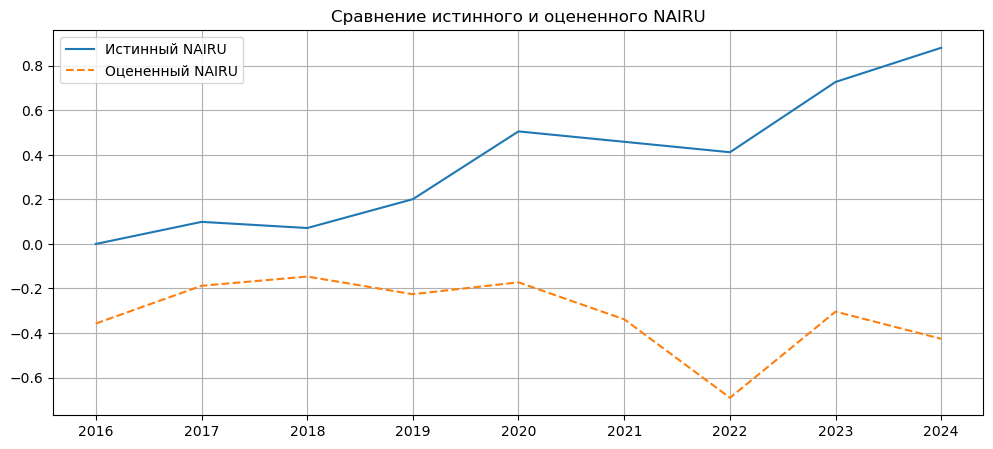

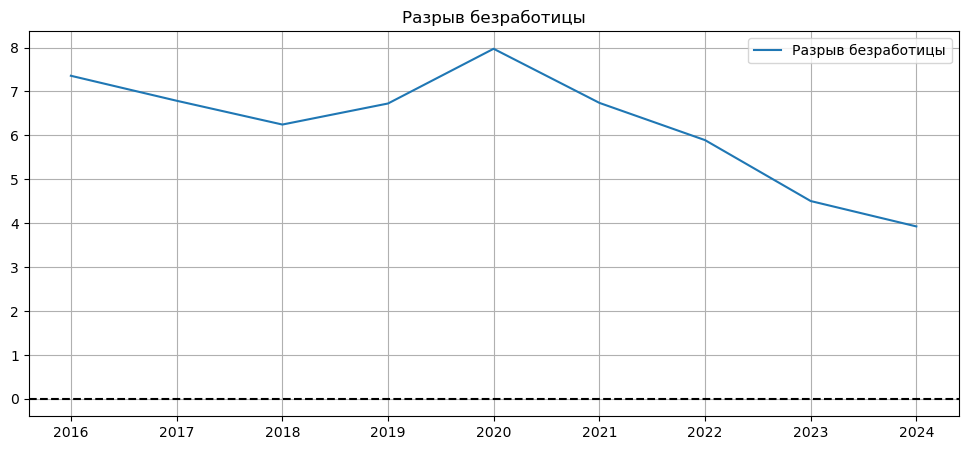

In [46]:
## Визуализация результатов

# Получаем оценки скрытых состояний
states = res.states.smoothed

df_results = pd.DataFrame({
    'NAIRU_estimated': states[:, 0],
    'Inflation_Expectations': states[:, 1],
    'Unemployment': df['unemployment'],
    'NAIRU_true': df['NAIRU_true']
})

# Построим график NAIRU
plt.figure(figsize=(12, 5))
plt.plot(df_results['NAIRU_true'], label='Истинный NAIRU')
plt.plot(df_results['NAIRU_estimated'], '--', label='Оцененный NAIRU')
plt.legend()
plt.title('Сравнение истинного и оцененного NAIRU')
plt.grid(True)
plt.show()

# Разрыв безработицы
df_results['Gap'] = df_results['Unemployment'] - df_results['NAIRU_estimated']

plt.figure(figsize=(12, 5))
plt.plot(df_results['Gap'], label='Разрыв безработицы')
plt.axhline(0, color='black', linestyle='--')
plt.title('Разрыв безработицы')
plt.grid(True)
plt.legend()
plt.show()

In [47]:
print(df_results)

            NAIRU_estimated  Inflation_Expectations  Unemployment  NAIRU_true  \
Date                                                                            
2016-01-01        -0.357522                0.000270           7.0    0.000000   
2017-01-01        -0.187824                0.000238           6.6    0.099343   
2018-01-01        -0.146320                0.000230           6.1    0.071690   
2019-01-01        -0.225761                0.000245           6.5    0.201228   
2020-01-01        -0.172173                0.000235           7.8    0.505834   
2021-01-01        -0.338834                0.000267           6.4    0.459003   
2022-01-01        -0.691000                0.000333           5.2    0.412176   
2023-01-01        -0.303786                0.000260           4.2    0.728018   
2024-01-01        -0.426056                0.000283           3.5    0.881505   

                 Gap  
Date                  
2016-01-01  7.357522  
2017-01-01  6.787824  
2018-01-01  6.24